# Local Measures of Spatial Autocorrelation - Moran's I

The focus of this notebooks is on evaluation of local spatial autocorrelation. 

Concepts covered include: a) neighborhood analysis, b) local Moran test, c) multiple testing, d) cluster mapping.

In [1]:
# Load relevant R packages
inLibraries = list('repr','rgdal','spdep','classInt')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

## Spatial Autocorrelation in Cancer Incidence Rates

In this project, I will work with the New York Cancer Registry dataset. Details regarding this registry can be found at(https://www.health.ny.gov/statistics/cancer/registry/Read).  This particular dataset reflects information on the spatial distribution of incidence of prostate cancer as summarized at the zip code level (https://www.health.ny.gov/statistics/cancer/registry/zipcode/index.htm). One can find the zip code polygons and the associated prostate cancer data at (newyork_cancer/NYzipUTM.shp).  

In [2]:
#Read in the featureclass
inFeatures <- readOGR("/dsa/data/geospatial/DS8612/newyork_cancer","NYzipUTM")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/newyork_cancer", layer: "NYzipUTM"
with 1384 features
It has 8 fields


## Defining Neighborhoods

The first step is to define neighborhoods for each feature (zip code areas in this case). One way to accomplish this for polygon data is to use the poly2nb() function (spdep library).

In [3]:
#Identify the neighbors of each feature
inFeatures.nb <- poly2nb(inFeatures,queen=TRUE)

## Validating Inputs

It is good to check the neighborhoods for features and only retain those features that have a valid neighborhood. To do this, the cardinality (number of elements in a set) of each neighborhood is first examined using the card() function (spdep library). Next, only those features with at least a cardinality of one (one neighbor) are selected. The Queen's criterion is applied and then neighborhoods are transformed into lists.

In [4]:
#Select features with at least one neighbor
inFeaturesSubset <- inFeatures[card(inFeatures.nb) >= 1, ]

#Identify the neighbors of each feature having at least one neighbor
inFeaturesSubset.nb <- poly2nb(inFeaturesSubset, queen=TRUE)

#Retrieve neighborhood list
inFeaturesSubset.listb <- nb2listw(inFeaturesSubset.nb,style="B")
inFeaturesSubset.listw <- nb2listw(inFeaturesSubset.nb,style="W")

## Feature Attribute to Analyze

In most assessments of spatial autocorrelation, some attribute of each feature is compared relative to that of it's neighbors. Therefore, let's select an attribute to analyze. Here, incidence rate over the population is examined. In this case, prostate cancer incidence 'ObsIncid' is taken relative to the male population 'MalePop'. Just to ensure that every feature can be associated with a rate (i.e. in the event that no population exists in an area), the rate variable is checked for Null and set to 0.0 if such instances exist.

In [5]:
#retrieve variables
inVa <- inFeaturesSubset$ObsIncid
inVb <- inFeaturesSubset$MalePop

#incident rate variables
VarA <- (inVa/inVb)

#if a variable is Null/NaN, set to zero so there are no missing values
VarA[is.nan(VarA)] <- 0

## Map the analysis variable

Plot the analysis variable to visualize its spatial distribution.

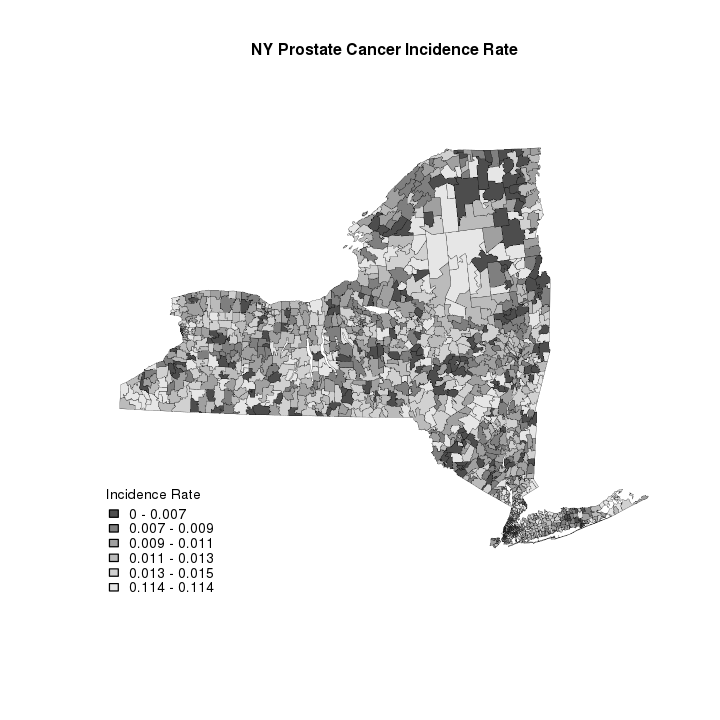

In [6]:
#classify variable
numcat <- 6
cate <- classIntervals(VarA,numcat,style="quantile")

#plot classified variable
pal1 <- gray.colors(numcat)
cols <- findColours(cate,pal1)
plot(inFeaturesSubset,col=cols,lwd=.2,main="NY Prostate Cancer Incidence Rate",cex.main=.8)
brks <- round(cate$brks,3)
leg.text <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft",fill=attr(cols,"palette"),legend=leg.text,bty="n",title="Incidence Rate",cex=.7)

## Compute the Local Moran Statistic

It is also possible to compute the Moran statistic for each feature vs for the entire set of features as a whole. This type of computation is called a local spatial statistic. Just as with the global Moran's I, the null hypothesis is that the variable is distributed randomly among the features in the region. In this example, the localmoran() function (spdep library) is used to compute the local Moran statistic. The localmoran() function requires the analysis variable, a .listw list of spatial neighbors and the form of the hypothesis to be tested.  Here, the two.sided hypothesis is of interest.  Then, the Moran value, the z-score and the p-value for each feature are retrieved.

In [7]:
#Compute local Moran
feat.MIi <- localmoran(VarA, inFeaturesSubset.listw,alternative="two.sided")

#look at the fields of the result object to find the index of the desired attributes
colnames(feat.MIi)

#retrieve the Moran I value, the z-score and the p-value
iMIi <- feat.MIi[,1]
zMIi <- feat.MIi[,4]
prMIi <- feat.MIi[,5]

[1] "Ii"         "E.Ii"       "Var.Ii"     "Z.Ii"       "Pr(z != 0)"

### Plot the Local Moran z-scores

Before the z-scores can be mapped, one should determine which z-scores are significant at a particular level. That task means a reference distribution is needed.  First, let's compare the z-scores to the normal distribution to determine which ones are significant at several different confidence levels - 0.90 and 0.95.  

### Normal z-scores

If is believed that the z-scores follow a traditionally defined normal distribution, then z-scores for the needed levels of confidence can be obtained as follows.

In [8]:
#Normal z-scores
#list of normal z-scores
zNormal <- list()

#we'll z-scores corresponding to each of these levels of confidence
probsU <- c(0.90, 0.95)

#compute higher levels
i <- 1
for (pr in probsU) {    
    #convert confidence levels to significance probs.
    inpr <- 1-((1-pr)/2)
    #compute normal error for z-score
    errorZ <- qnorm(inpr,lower.tail=TRUE)
    zNormal[[i]] <- 0 + errorZ    
    i <- i+1
}

zM <- unlist(zNormal)

#for each confidence level, print the confidence level and corresponding z-score
paste(probsU,zM,sep="   ")

[1] "0.9   1.64485362695147"  "0.95   1.95996398454005"

### Map the normally distribution z-scores for the relative p-values

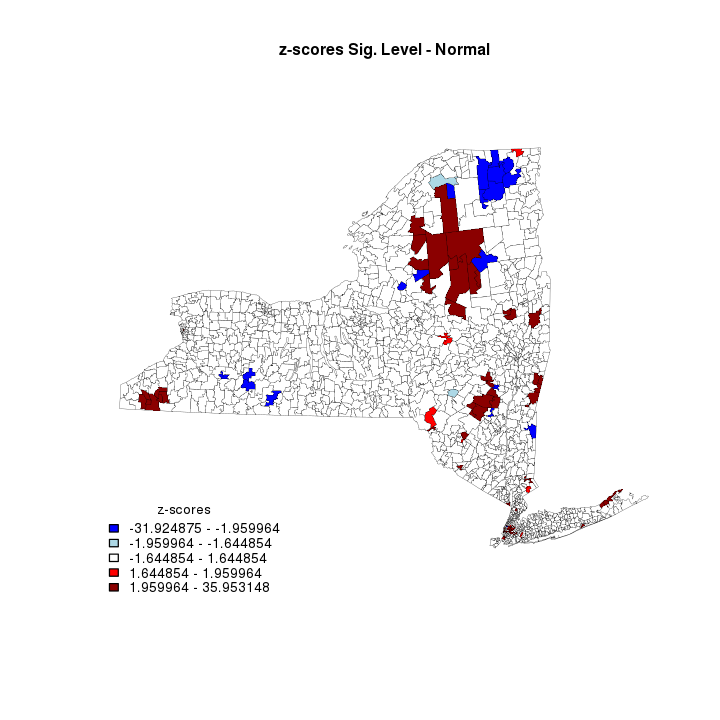

In [9]:
#classify normal z-score significance
ncz1 <- 4 + length(zM) - 1
ncz2 <- 4 + length(zM)
zM.MIi <- classIntervals(zMIi,n=ncz1, style="fixed",fixedBreaks=c(min(zMIi), -zM,zM, max(zMIi)))

#plot classified z-scores
pal1 <- c("blue","lightblue","white","red1","red4")
cols.MIi <- findColours(zM.MIi, pal1)
plot(inFeaturesSubset, col=cols.MIi,lwd=.2,main="z-scores Sig. Level - Normal",cex.main=.8)
brks <- round(zM.MIi$brks, ncz2)
leg <- paste(brks[-ncz2], brks[-1], sep=" - ")
legend("bottomleft", fill=pal1, legend=leg, bty="n",title="z-scores",cex=.7)

## Multiple testing

The significance values (p-values) are 'uncorrected' at this point. That is, they don't account for potential spatial dependencies and/or testing of alternative hypotheses. As such, instead of simply evaluating our hypothesis based on the uncorrected p-values, it's worthwhile testing the hypothesis in several other ways. One way to do this is to configure the z-scores to be interpreted in different ways: a) adjusted normal dist, b) t-statistic adjusted, c) Bonferroni adjustment, etc. For a) and b) adjustments will depend on ESS.

### First, compute the ESS

In [10]:
#Compute effective sample size
feat.d.sar <- errorsarlm(VarA ~1, listw=inFeaturesSubset.listw)
rho <- feat.d.sar$lambda
rho2 <- unname(rho)

#compute set size of observed z-score distribution
dvalues <- length(inFeaturesSubset)

#Calculated effective sample size per Griffith's (2005) eq.
ESS <- dvalues * (1-(1/(1-exp(-1.92349)))*((dvalues-1)/dvalues)*(1-exp((-2.12373*rho2)+ (.20024*sqrt(rho2)))))
paste("ESS =",ESS,sep=" ")

[1] "ESS = 667.844095917588"

### Adjusted Normal Distribution p-values/z-scores

In [11]:
#list of adjusted normal z-score breakpts
zAdjusted <- list()

#find z-scores corresponding to each of these levels of confidence
probsU <- c(0.90, 0.95)

#compute higher levels
i <- 1
for (pr in probsU) {    
    rmean <- mean(VarA)
    newpr <- 1-(((1-pr)/ESS)/2)
    
    #compute error according to adjusted normal distribution
    errorN <- qnorm(newpr,mean=rmean,lower.tail=TRUE)
    zAdjusted[[i]] <-0 + errorN   
      
    i <- i+1
}

zcM <- unlist(zAdjusted)
#for each confidence level, print the confidence level and corresponding z-score
paste(probsU,zcM,sep="   ")

[1] "0.9   3.80313917456379" "0.95   3.9718929172627"

### Map the ESS adjusted Normally Distributed p-values/z-scores

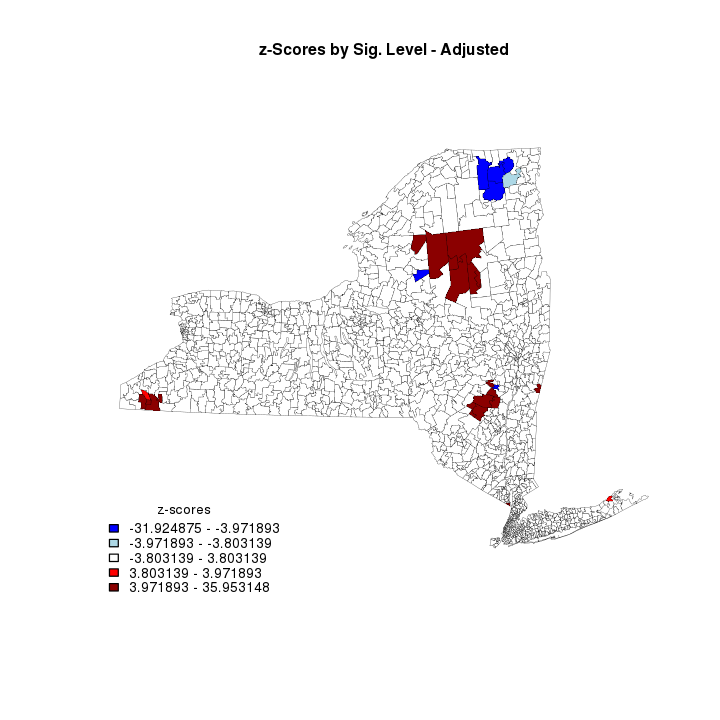

In [12]:
#classifying adjusted z-score significance
nczc1 <- 4 + length(zcM) - 1
nczc2 <- 4 + length(zcM)
zcM.MIi <- classIntervals(zMIi,n=nczc1, style="fixed",fixedBreaks=c(min(zMIi), -zcM, zcM, max(zMIi)))

pal2 <- c("blue","lightblue","white","red1","red4")
cols.MIi <- findColours(zcM.MIi, pal2)
plot(inFeaturesSubset, col=cols.MIi,lwd=.2,main="z-Scores by Sig. Level - Adjusted",cex.main=.8)
brks <- round(zcM.MIi$brks, nczc2)
leg <- paste(brks[-nczc2], brks[-1], sep=" - ")
legend("bottomleft", fill=pal2, legend=leg, bty="n",title="z-scores",cex=.7)

### ESS adjusted t-distribution p-values/z-scores

In [13]:
#list of adjusted t statistic z-score breakpts
zTStatAdjusted <- list()

#find z-scores corresponding to each of these levels of confidence
probsU <- c(0.90, 0.95)

#compute higher levels
i <- 1
for (pr in probsU) {       
    #modify the probability to account for ESS
    newpr <- 1-(((1-pr)/ESS)/2)
    
    #compute error for t-statistic    
    errorT <- qt(newpr,df=ESS-2,lower.tail = TRUE) 
    zTStatAdjusted[[i]] <- 0 + errorT
    
    i <- i+1
}

tcM <- unlist(zTStatAdjusted)

#for each confidence level, print the confidence level and corresponding z-score
paste(probsU,tcM,sep="   ")

[1] "0.9   3.81350904801856"  "0.95   3.98520751538414"

### Map ESS adjusted t-distribution z-scores

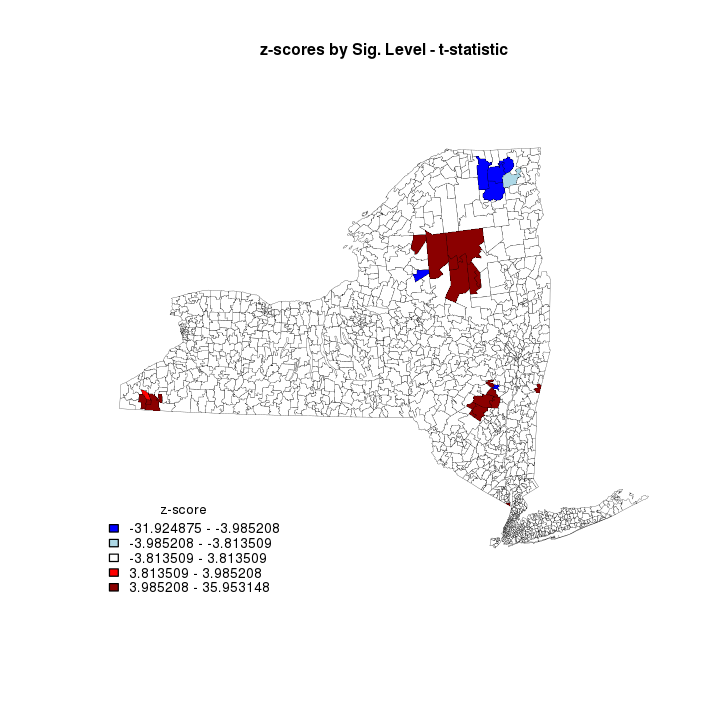

In [14]:
#classify adjusted significance
nctc1 <- 4 + length(tcM) - 1
nctc2 <- 4 + length(tcM)
tcM.MIi <- classIntervals(zMIi,n=nctc1, style="fixed",fixedBreaks=c(min(zMIi), -tcM, tcM,  max(zMIi)))

#plot z-scores
pal3 <- c("blue","lightblue","white","red1","red4")
cols.MIi <- findColours(tcM.MIi, pal3)
plot(inFeaturesSubset, col=cols.MIi,lwd=.2,main="z-scores by Sig. Level - t-statistic",cex.main=.8)
brks <- round(tcM.MIi$brks, nctc2)
leg <- paste(brks[-nctc2], brks[-1], sep=" - ")
legend("bottomleft", fill=pal3, legend=leg, bty="n",title="z-score",cex=.7)

### z-score significance using a Bonferroni correction

In [15]:
#list of bonferroni corrected z-score breakpts
zBNAdjusted <- list()

#find z-scores corresponding to each of these levels of confidence
probsU <- c(0.90, 0.95)

#compute set size of observed z-score distribution
dval <- length(inFeaturesSubset)

#compute higher levels
i <- 1
for (pr in probsU) {    
    #compute error according to bonferonni adjustment
    berpr <- 1-(((1-pr)/dval)/2)
    errorBN <- qnorm(berpr,lower.tail=TRUE)
    zBNAdjusted[[i]] <- 0 + errorBN    
    i <- i+1
}

bfcM <- unlist(zBNAdjusted)
#for each confidence level, print the confidence level and corresponding z-score
paste(probsU,bfcM,sep="   ")

[1] "0.9   3.96822057594178"  "0.95   4.13044832063272"

### Map Bonferroni Corrected z-scores

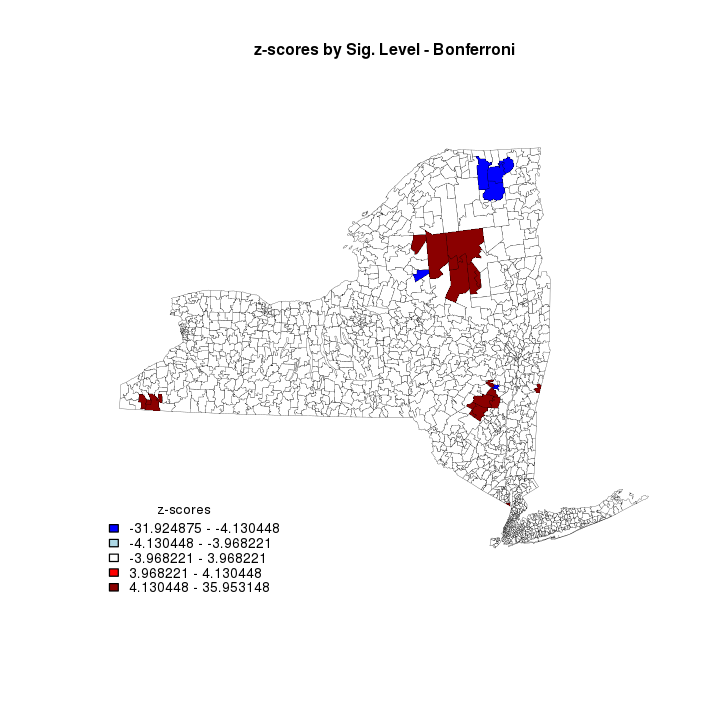

In [16]:
#classify adjustment significance 
ncbf1 <- 4 + length(bfcM) - 1
ncbf2 <- 4 + length(bfcM)
bfcM.MIi <- classIntervals(zMIi,n=ncbf1, style="fixed",fixedBreaks=c(min(zMIi), -bfcM, bfcM, max(zMIi)))

#plot z-scores
pal5 <- c("blue","lightblue","white","red1","red4")
cols.MIi <- findColours(bfcM.MIi, pal5)
plot(inFeaturesSubset, col=cols.MIi,lwd=.2,main="z-scores by Sig. Level - Bonferroni",cex.main=.8)
brks <- round(bfcM.MIi$brks, ncbf2)
leg <- paste(brks[-ncbf2], brks[-1], sep=" - ")
legend("bottomleft", fill=pal5, legend=leg, bty="n",title="z-scores",cex=.7)

## Identifying Types of Autocorrelation

The quadrants of the Moran scatterplot can be used to denote different types of clustering. Let's use this notion to map out significant clustering levels. In the scatterplot, the x-axis was the analysis variable while the y-axis was the lagged analysis variable (average of each features neighborhood). 

First, we'll calculate the global mean of the analysis variable. Second, we'll iterate through each features neighbor and calculate the local mean of the lagged variable. Third, we need to add columns to the dataframe named Cluster and Color that can be attributed with type of autocorrelation (i.e. HH = high value surrounded by areas of high value) and a color code respectively. Finally, compare the analysis variable to the global and local mean in order to categorize the type of clustering that exists. Note that the zM[1] variable was one that we created earlier to represent the z-scores significant at the .90 confidence level.  If I need to restrict the output to clustering that's signifcant at the .95 level, then change zM[2].

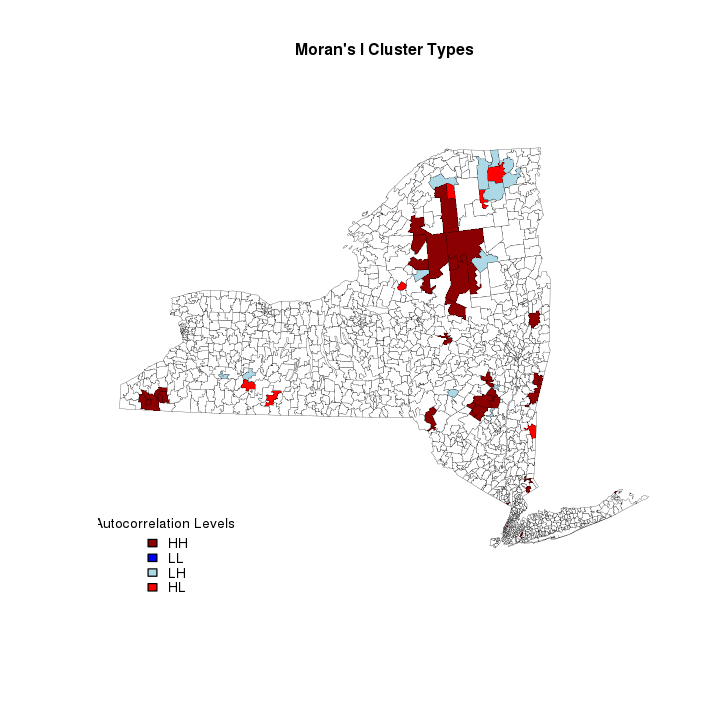

In [17]:
#calculate global mean of analysis variable
Gmean <- mean(VarA)

#calculate local mean of spatially lagged variables
vlist <- list()
nid <- 1
for (ele in inFeaturesSubset.listb$neighbours) {
    fee <- unlist(ele)
    ncard <- length(fee)
    
    vsum <- 0
    for (ef in fee) {        
        vsum <- vsum + VarA[ef]
    }
    vlist[[nid]] <- vsum
    nid <- nid + 1
   
}
Lmean <- mean(unlist(vlist))


#select areas that are significant and exhibit different categories of clustering
inFeaturesSubset$Cluster.col <- 0
inFeaturesSubset$Color.col <- 0
nid <- 1
for (ele in VarA) {
    
    if ((ele >= Gmean) && (vlist[nid] >= Lmean) && (zMIi[nid] >= zM[1])) {
        inFeaturesSubset$Cluster.col[nid] <- 'HH'
        inFeaturesSubset$Color.col[nid] <- 'red4'
        }   
    if ((ele <= Gmean) && (vlist[nid] <= Lmean) && (zMIi[nid] <= -zM[1])) {
        inFeaturesSubset$Cluster.col[nid] <- 'LL'
        inFeaturesSubset$Color.col[nid] <- 'blue'
        }
    
    if ((ele >= Gmean) && (vlist[nid] <= Lmean) && (zMIi[nid] <= -zM[1])) {
        inFeaturesSubset$Cluster.col[nid] <- 'HL'
        inFeaturesSubset$Color.col[nid] <- 'red'
        }   
    if ((ele <= Gmean) && (vlist[nid] >= Lmean) && (zMIi[nid] <= -zM[1])) {
        inFeaturesSubset$Cluster.col[nid] <- 'LH'
        inFeaturesSubset$Color.col[nid] <- 'lightblue'
        }
     
    
    nid <- nid + 1
    
}

#map the autocorrelation categories
plot(inFeaturesSubset, col=inFeaturesSubset$Color.col,lwd=.2,main="Moran's I Cluster Types",cex.main=.8)
legend("bottomleft",legend=c("HH","LL","LH","HL"),unique(inFeaturesSubset$Cluster.col),
       fill=c("red4","blue","lightblue","red"),bty='n',title='Autocorrelation Levels',cex=.7)

### Other Multiple Testing Options

Most of the z-score/p-value adjustment described above are applied to the entire set of z-scores/p-values in the same way. However, an adjustment or correction can be applied to each individual feature given the characteristics of its neighborhood. For example, the Bonferroni correction can be applied to each features neighbors given that every feature could have a different number of neighbors. These individual adjustments can be made by introducing the p.adjust.method() into the localmoran() syntax. Options included for p.adjustmethod include 'bonferroni','fdr','holm' among others. I will look at the Moran I...but we can try others. We can change the code below to hopefully see that the bonferroni is the most conservative.

In [25]:
#Compute local Moran using false discovery rate
feat.MIib <- localmoran(VarA, inFeaturesSubset.listw,alternative="two.sided",p.adjust.method="fdr")

#look at the fields of the result object to find the index of the desired attributes
colnames(feat.MIib)

#retrieve the Moran I value, the z-score and the p-value
iMIib <- feat.MIib[,1]
zMIib <- feat.MIib[,4]
prMIib <- feat.MIib[,5]

[1] "Ii"         "E.Ii"       "Var.Ii"     "Z.Ii"       "Pr(z != 0)"

### Map hot/cold spots (fdr method)

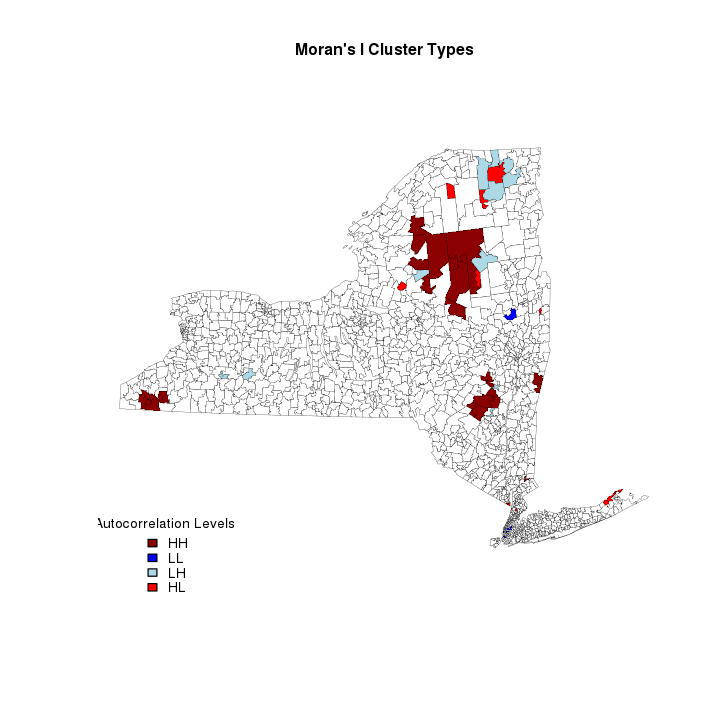

In [26]:
#calculate global mean of analysis variable
Gmean <- mean(VarA)

#calculate local mean of spatially lagged variables
vlist <- list()
nid <- 1
for (ele in inFeaturesSubset.listb$neighbours) {
    fee <- unlist(ele)
    ncard <- length(fee)
    
    vsum <- 0
    for (ef in fee) {        
        vsum <- vsum + VarA[ef]
    }
    vlist[[nid]] <- vsum
    nid <- nid + 1
   
}
Lmean <- mean(unlist(vlist))


#select areas that are significant and exhibit different categories of clustering
inFeaturesSubset$Cluster.col <- 0
inFeaturesSubset$Color.col <- 0
nid <- 1
for (ele in VarA) {
    
    if ((ele >= Gmean) && (vlist[nid] >= Lmean) && (prMIib[nid] <= 0.10)) {
        inFeaturesSubset$Cluster.col[nid] <- 'HH'
        inFeaturesSubset$Color.col[nid] <- 'red4'
        }   
    if ((ele <= Gmean) && (vlist[nid] <= Lmean) && (prMIib[nid] <= 0.10)) {
        inFeaturesSubset$Cluster.col[nid] <- 'LL'
        inFeaturesSubset$Color.col[nid] <- 'blue'
        }
    
    if ((ele >= Gmean) && (vlist[nid] <= Lmean) && (prMIib[nid] <= 0.10)) {
        inFeaturesSubset$Cluster.col[nid] <- 'HL'
        inFeaturesSubset$Color.col[nid] <- 'red'
        }   
    if ((ele <= Gmean) && (vlist[nid] >= Lmean) && (prMIib[nid] <= 0.10)) {
        inFeaturesSubset$Cluster.col[nid] <- 'LH'
        inFeaturesSubset$Color.col[nid] <- 'lightblue'
        }
     
    
    nid <- nid + 1
    
}

#map the autocorrelation categories
plot(inFeaturesSubset, col=inFeaturesSubset$Color.col,lwd=.2,main="Moran's I Cluster Types",cex.main=.8)
legend("bottomleft",legend=c("HH","LL","LH","HL"),unique(inFeaturesSubset$Cluster.col),
       fill=c("red4","blue","lightblue","red"),bty='n',title='Autocorrelation Levels',cex=.7)